# Anova Analysis of IMD Metrics

### Import Packages

In [1]:
import pandas as pd, numpy as np, matplotlib.pyplot as plt, geopandas as gpd, datetime, glob, math, openpyxl
import matplotlib.pyplot as plt, matplotlib.dates as mdates
from statistics import mean
from scipy import stats
from sklearn import datasets, linear_model
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import TweedieRegressor

plt.rcParams['figure.dpi'] = 300

### Import and Label Data

In [2]:
# set the filepath and load in a shapefile
fp = "./output_test.shp"
merged = gpd.read_file(fp)

In [3]:
# what are the column names of the input files?
merged.columns

Index(['LAD21NM', 'OBJECTID', 'LAD21CD', 'BNG_E', 'BNG_N', 'LONG', 'LAT',
       'Shape__Are', 'Shape__Len', 'area code', 'Cumulative', 'IMD_ Overa',
       'IMD_ Barri', 'IMD_ Crime', 'IMD_ Educa', 'IMD_ Emplo', 'IMD_ Healt',
       'IMD_ Incom', 'IMD_ Livin', 'Cumulati_1', 'Cumulati_2', 'Total popu',
       'Cumulati_3', 'Cumulati_4', 'Cumulati_5', 'IMD_ Ove_1', 'Cumulati_6',
       'Cumulati_7', 'IMD_ Ove_2', 'Cumulati_8', 'IMD_ Ove_3', 'IMD_ Ove_4',
       'geometry'],
      dtype='object')

In [4]:
# give the columns more appropriate names

merged.columns = ['LAD21NM', 'OBJECTID', 'LAD21CD', 'BNG_E', 'BNG_N', 'LONG', 'LAT', 'Shape__Are','Shape__Len', 
                  'area code', 'Cumulative confirmed cases', 
                  'IMD: Overall - extent (%)',
                  'IMD: Barriers to Housing and Services',
                  'IMD: Crime',
                  'IMD: Education Skills and Training Deprivation',
                  'IMD: Employment',
                  'IMD: Health Deprivation and Disability',
                  'IMD: Income Deprivation',
                  'IMD: Living Environment Deprivation',
                  'Cumulative 1st dose', 'Cumulative 2nd dose','Total population', 
                  'Cumulative 1st dose per 100k', 'Cumulative 2nd dose per 100k', 
                  'Cumulative confirmed cases per 100k','IMD: Overall - extent (%) per 100k', 
                  'Cumulative 1st dose by Cumulative 2nd dose','Cumulative 1st dose by Cumulative confirmed cases', 
                  'IMD: Overall - extent (%) by Cumulative 1st dose', 
                  'Cumulative 2nd dose by Cumulative confirmed cases', 
                  'IMD: Overall - extent (%) by Cumulative 2nd dose', 
                  'IMD: Overall - extent (%) by Cumulative confirmed cases', 'geometry']
merged = merged.set_index('LAD21NM')

In [5]:
merged.columns

Index(['OBJECTID', 'LAD21CD', 'BNG_E', 'BNG_N', 'LONG', 'LAT', 'Shape__Are',
       'Shape__Len', 'area code', 'Cumulative confirmed cases',
       'IMD: Overall - extent (%)', 'IMD: Barriers to Housing and Services',
       'IMD: Crime', 'IMD: Education Skills and Training Deprivation',
       'IMD: Employment', 'IMD: Health Deprivation and Disability',
       'IMD: Income Deprivation', 'IMD: Living Environment Deprivation',
       'Cumulative 1st dose', 'Cumulative 2nd dose', 'Total population',
       'Cumulative 1st dose per 100k', 'Cumulative 2nd dose per 100k',
       'Cumulative confirmed cases per 100k',
       'IMD: Overall - extent (%) per 100k',
       'Cumulative 1st dose by Cumulative 2nd dose',
       'Cumulative 1st dose by Cumulative confirmed cases',
       'IMD: Overall - extent (%) by Cumulative 1st dose',
       'Cumulative 2nd dose by Cumulative confirmed cases',
       'IMD: Overall - extent (%) by Cumulative 2nd dose',
       'IMD: Overall - extent (%) by Cumulat

In [6]:
# remove nans
merged = merged.dropna()

In [7]:
# only consider columns that start wth IMD
IMD_df = merged[merged.columns[merged.columns.str.startswith('IMD')]]

# remove any columns that contain '%', mainly 'IMD: Overall - extent (%)'
IMD_metrics_df = IMD_df[IMD_df.columns[~IMD_df.columns.str.contains('\%')]]

In [8]:
# compute the variance for each IMD metric and put them in a list in the form, (IMD metric name, IMD metric variance).
IMD_metric_variances = []

for i,col in enumerate(IMD_metrics_df.columns):
    IMD_metric_variances.append((col,IMD_metrics_df.iloc[:,i].var()))

In [9]:
# sort the variances from largest to smallest
IMD_metric_variances = sorted(IMD_metric_variances, key=lambda tup: tup[1])

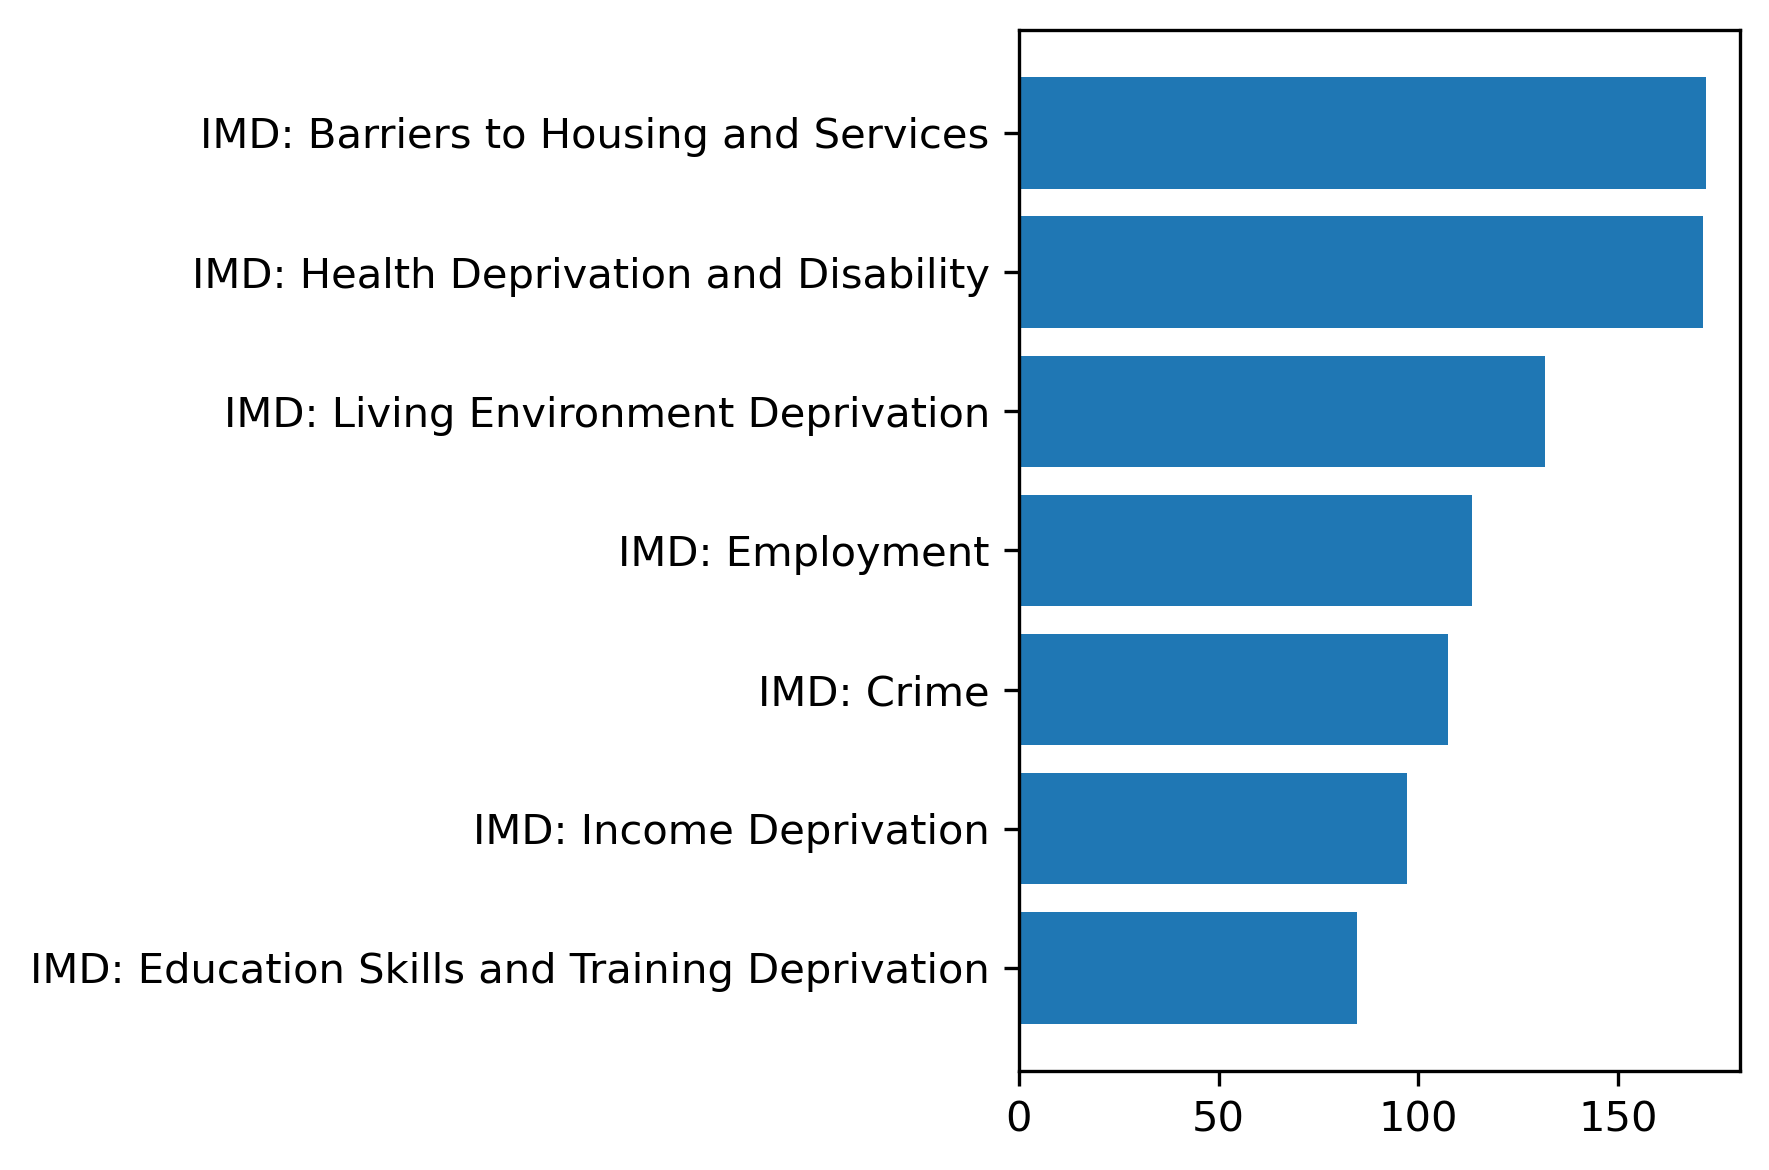

In [10]:
# plot the variances
title = 'The variances of IMD metrics between local authorities'

labels = [tup[0] for tup in IMD_metric_variances]
scores = [tup[1] for tup in IMD_metric_variances]

plt.barh(y=labels,width=scores)
#plt.title(title)
plt.tight_layout()
plt.savefig('./Desktop/MSc Project/Outputs/' + title + '.png')
plt.show()

In [11]:
# more drop nans for some reason
IMD_metrics_df = IMD_metrics_df.dropna()
IMD_metrics_df.head(3)

,IMD: Barriers to Housing and Services,IMD: Crime,IMD: Education Skills and Training Deprivation,IMD: Employment,IMD: Health Deprivation and Disability,IMD: Income Deprivation,IMD: Living Environment Deprivation
LAD21NM,,,,,,,
Hartlepool,0.0,32.76,20.69,43.10,36.21,37.93,0.00
Middlesbrough,0.0,45.35,39.53,48.84,56.98,50.00,0.00
Redcar and Cleveland,0.0,13.64,19.32,32.95,35.23,26.14,1.14


In [12]:
# some more formatting for next step
a = IMD_metrics_df.iloc[:,0].values
b = IMD_metrics_df.iloc[:,1].values
c = IMD_metrics_df.iloc[:,2].values
d = IMD_metrics_df.iloc[:,3].values
e = IMD_metrics_df.iloc[:,4].values
f = IMD_metrics_df.iloc[:,5].values
g = IMD_metrics_df.iloc[:,6].values

In [13]:
# 'The one-way ANOVA tests the null hypothesis that two or more groups have the same population mean. 
# The test is applied to samples from two or more groups, possibly with differing sizes.'
F, p = stats.f_oneway(a,b,c,d,e,f,g)

In [14]:
F

1.9003915577822814

This larger F value means that the groups probably do have different means. (the variation between groups is larger than the variation within groups.)

In [15]:
p

0.07724946774970076

This low p-value shows that this result is statistically significant.

Therefore there is a significant difference between IMD metrics.

# Histograms of IMD Metrics

C:\Users\joshb\AppData\Roaming\Python\Python38\site-packages\pandas\plotting\_matplotlib\tools.py:331: MatplotlibDeprecationWarning: 
The is_first_col function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use ax.get_subplotspec().is_first_col() instead.
  if ax.is_first_col():


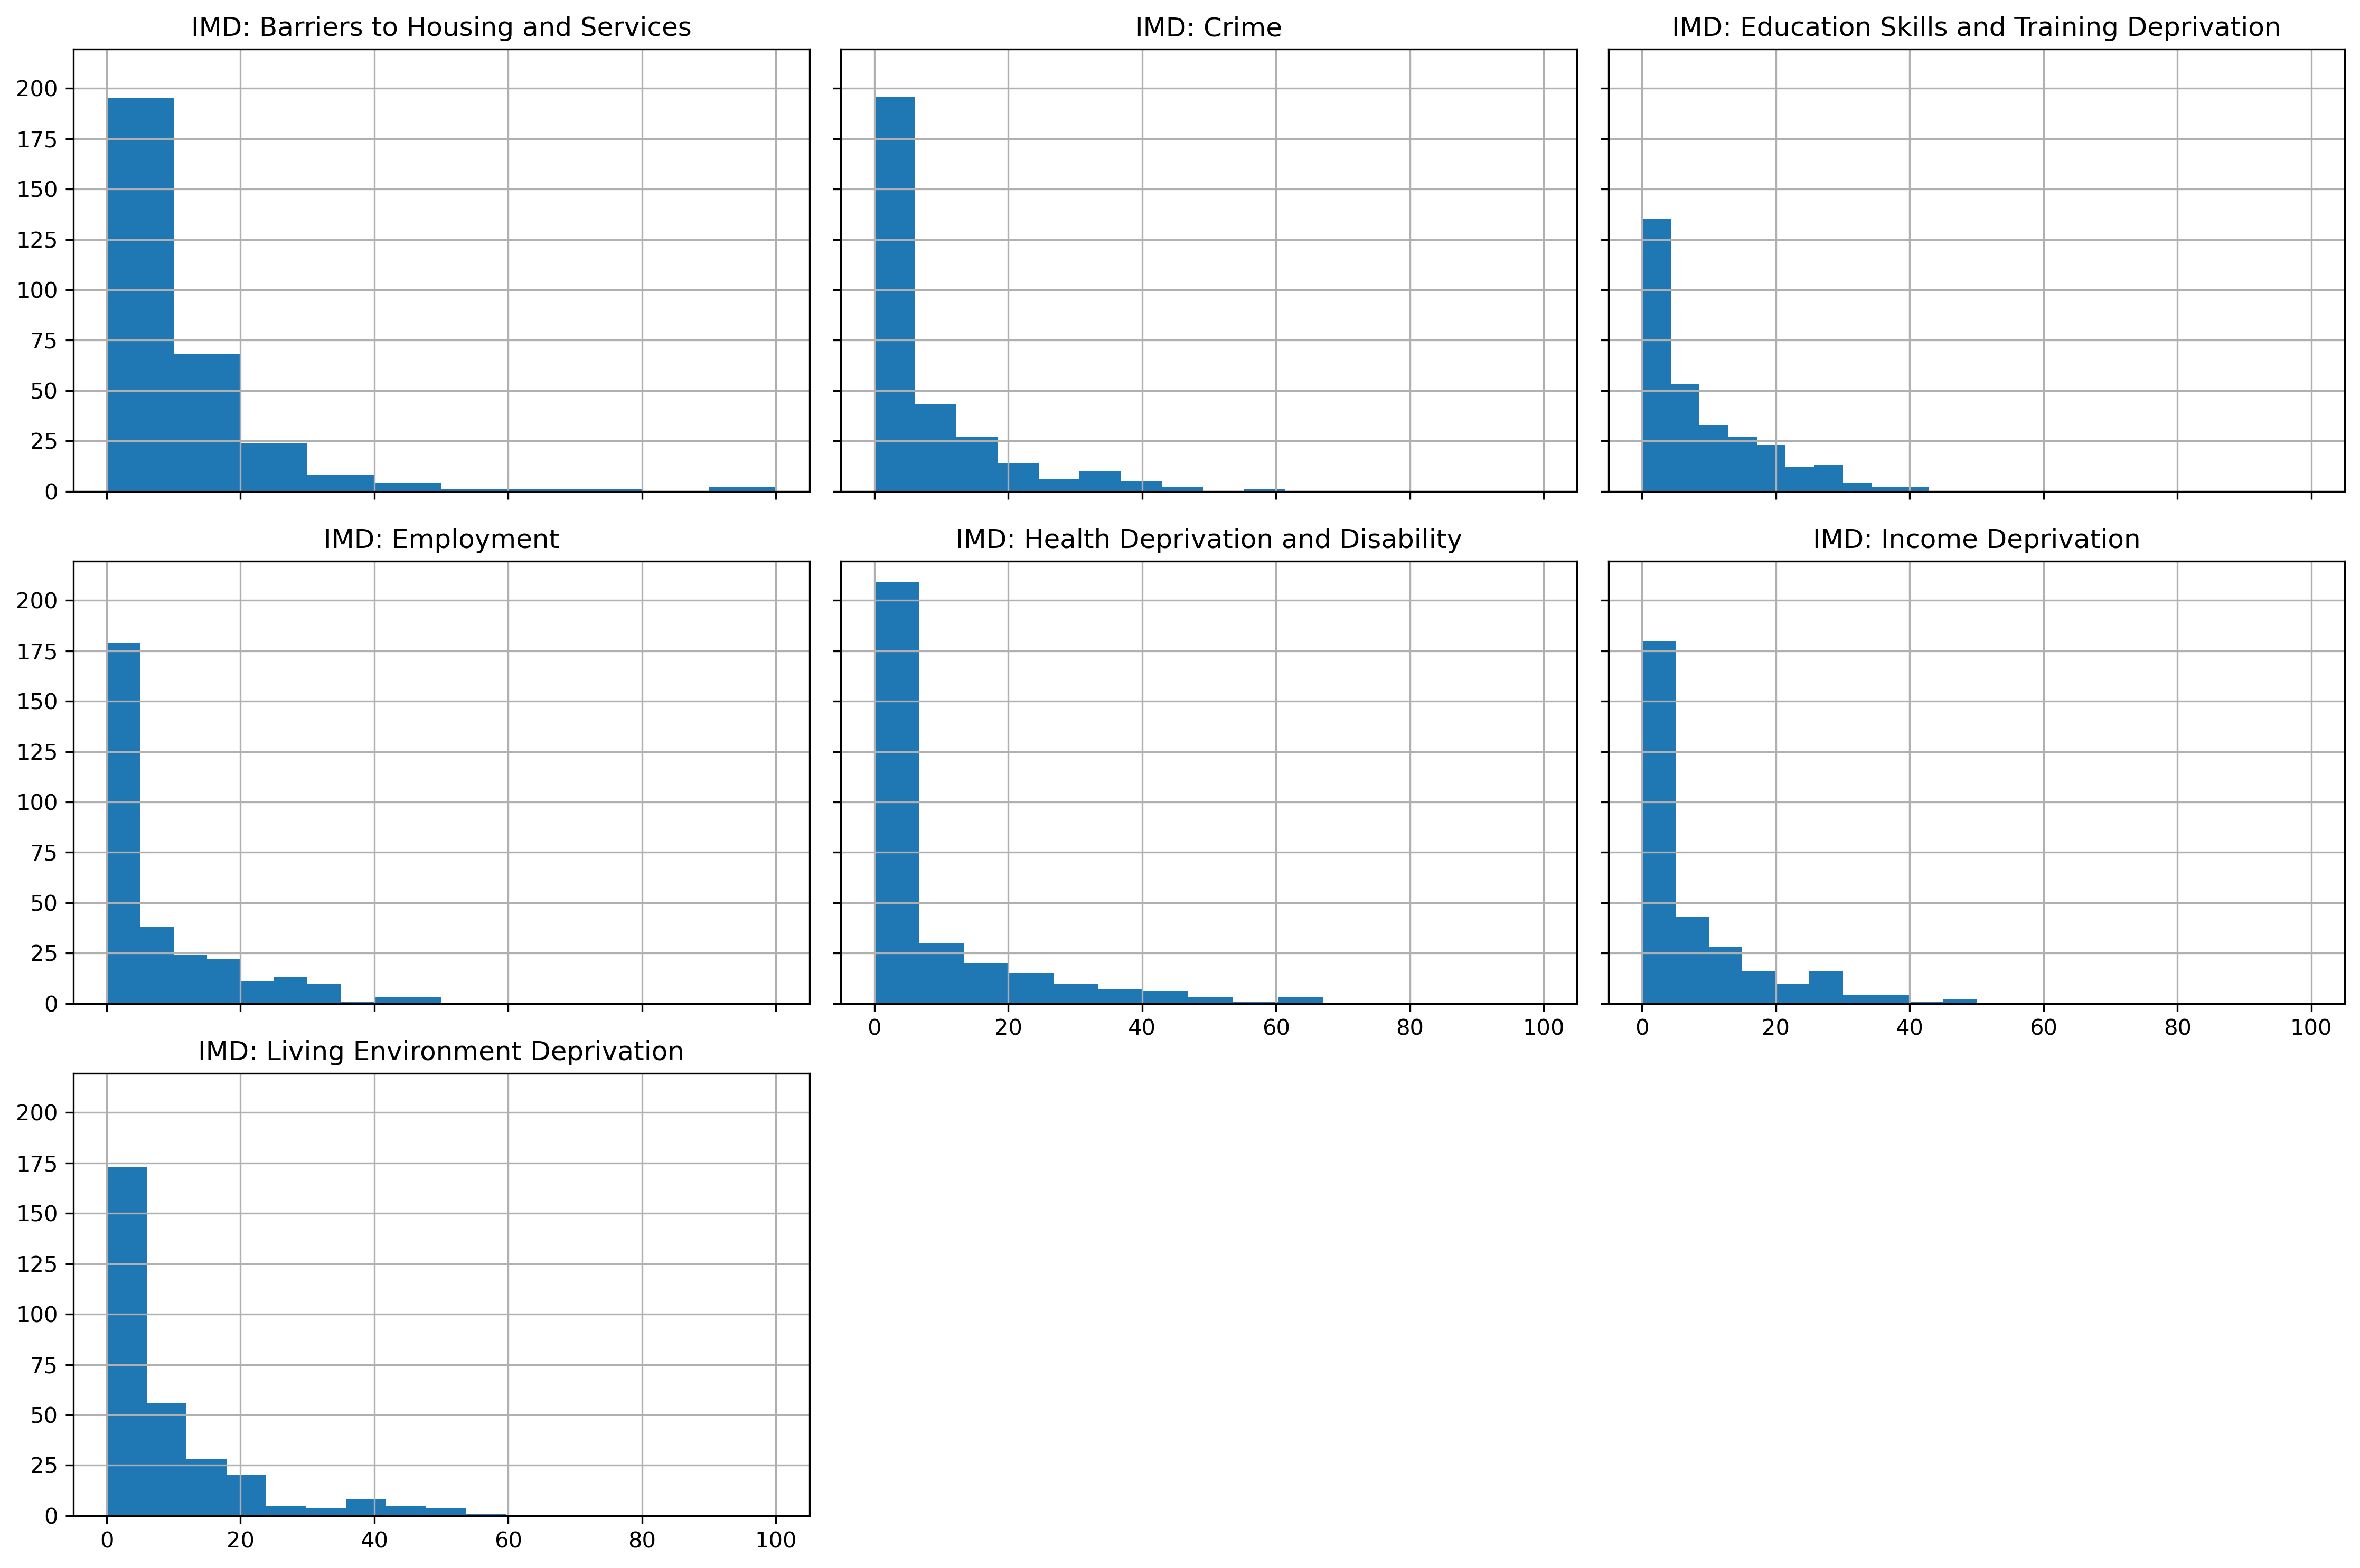

In [16]:
# plot histograms of the IMD metrics to explore variance
title = 'Histograms of IMD metrics stratified by local authority'

IMD_metrics_df.hist(figsize=(15,10),sharex=True,sharey=True)

#plt.suptitle(title)
plt.tight_layout()
plt.savefig('./Desktop/MSc Project/Outputs/' + title + '.png')
plt.show()

# Linear Regression Models [Number of Doses per 100k]

IMD: Barriers to Housing and Services
Mean squared error: 35548940
Coefficient of determination: -0.00
IMD: Crime
Mean squared error: 29456670
Coefficient of determination: 0.17
IMD: Education Skills and Training Deprivation
Mean squared error: 36470471
Coefficient of determination: -0.03
IMD: Employment
Mean squared error: 35716791
Coefficient of determination: -0.01
IMD: Health Deprivation and Disability
Mean squared error: 29456670
Coefficient of determination: 0.17
IMD: Income Deprivation
Mean squared error: 36470471
Coefficient of determination: -0.03
IMD: Living Environment Deprivation
Mean squared error: 35716791
Coefficient of determination: -0.01


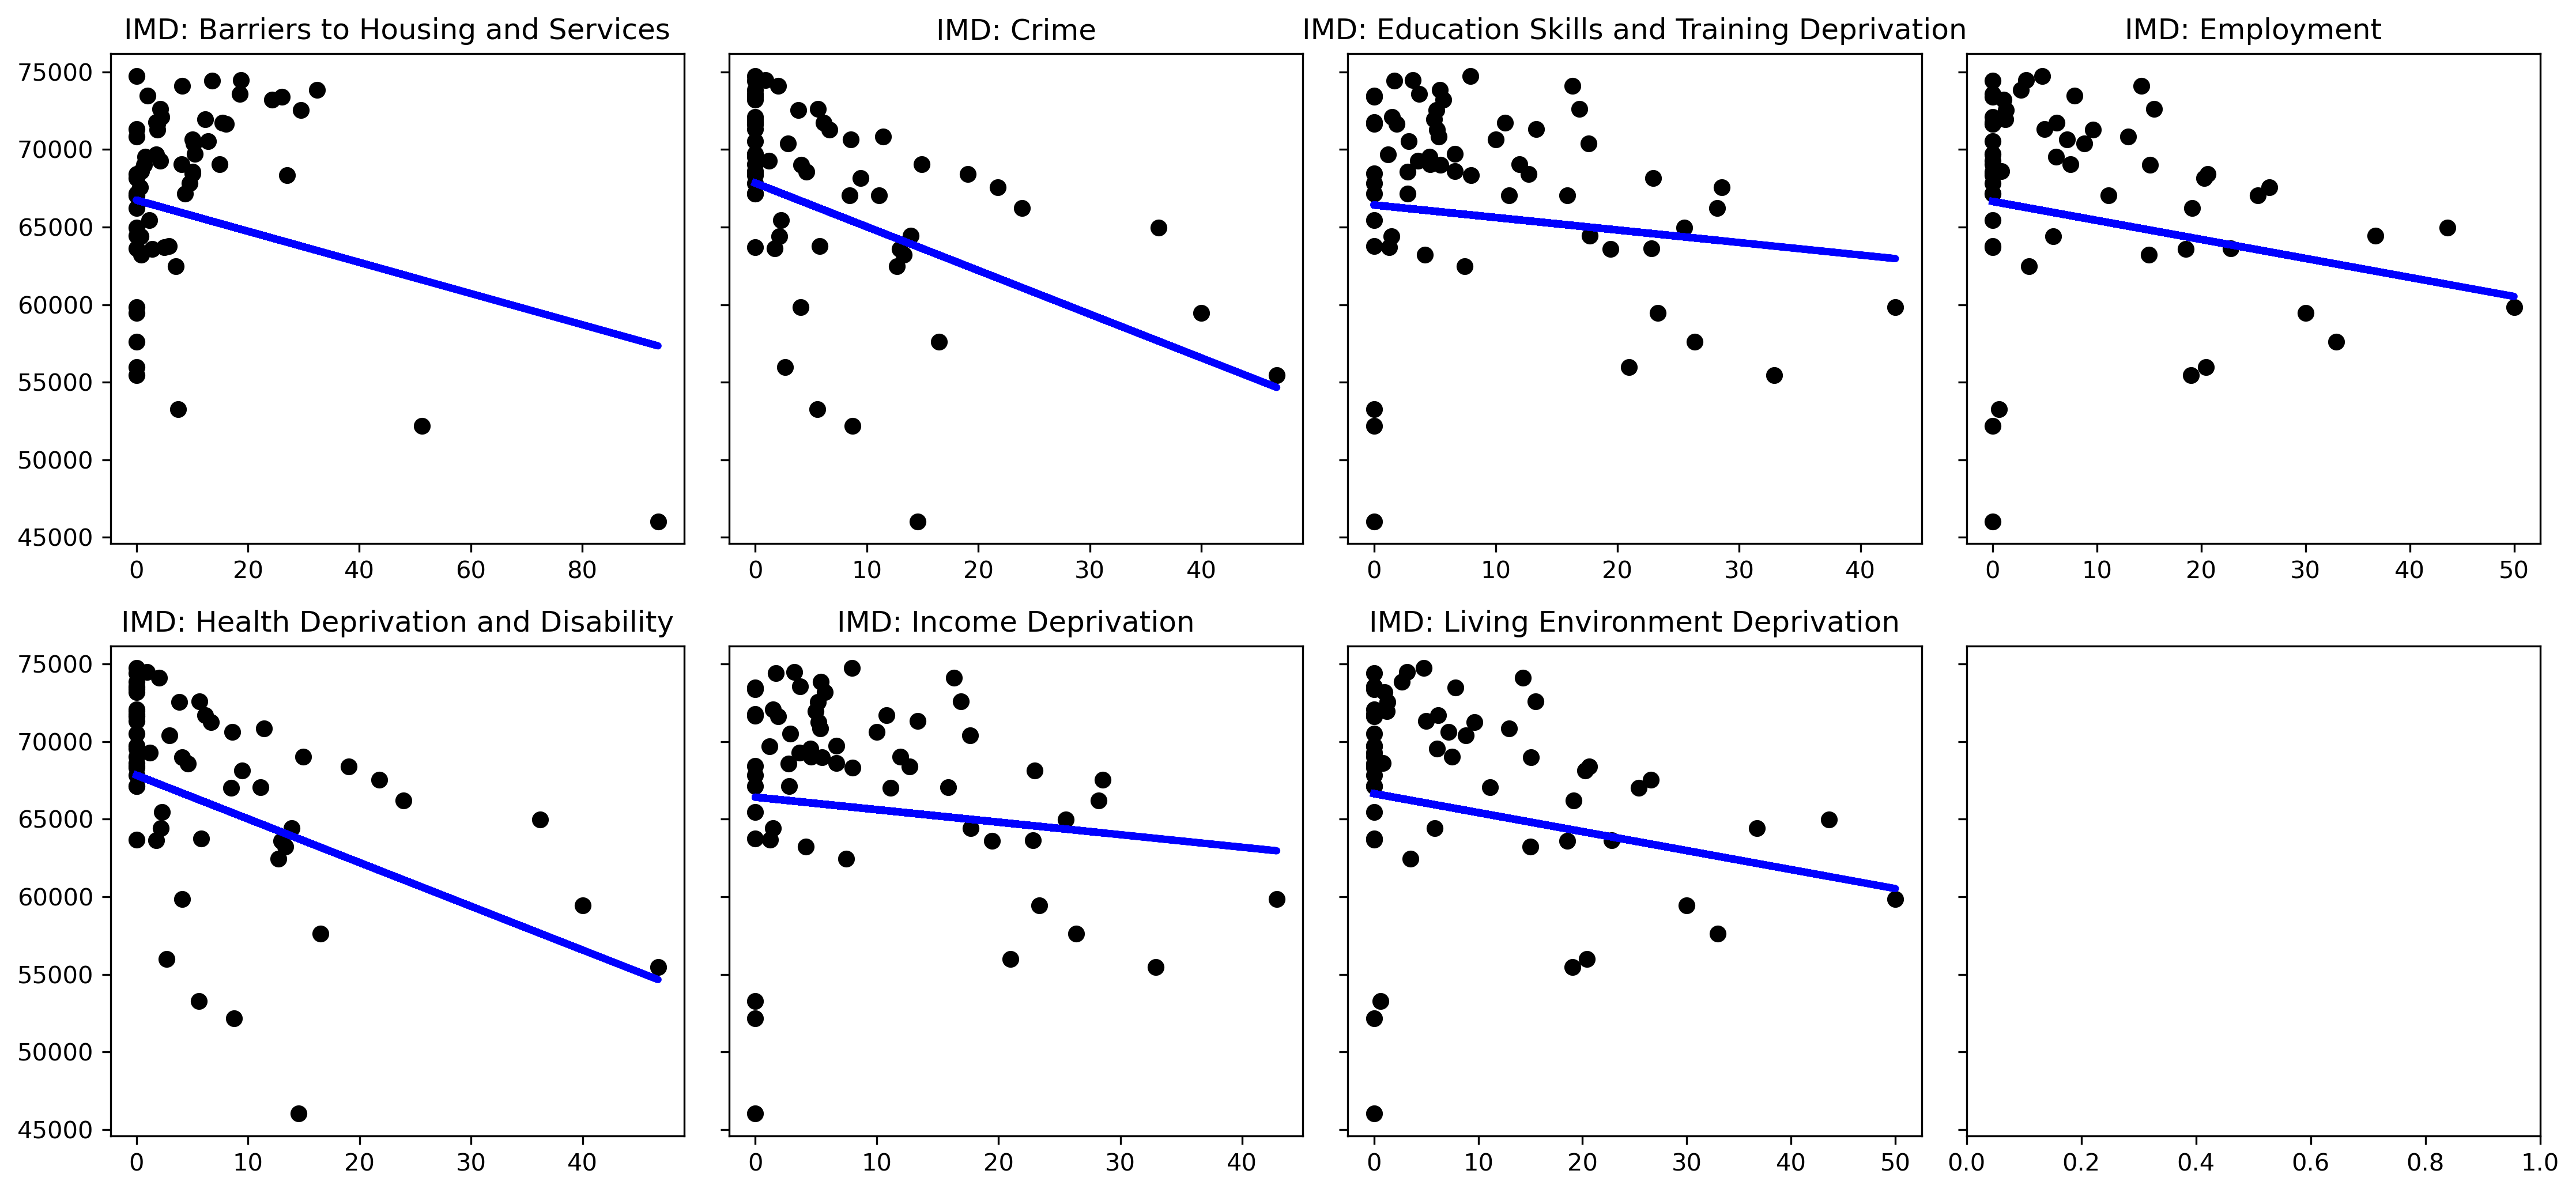

(None, None)

In [17]:
# perform linear regression on each IMD metric individually and plot
# outcome variable being number of doses per 100k
rows,cols=2,4
title = 'Linear Regression of Vaccine Rates per 100k and IMD Metrics'


fig, axes = plt.subplots(figsize=(15,7),nrows=rows, ncols=cols, sharey=True)

for i in range(rows):
    for j in range(cols):
        if i*j==3:
            continue
        else:
            # Load the dataset
            X,y = IMD_metrics_df.iloc[:,i+j],merged['Cumulative 1st dose per 100k']

            # Split the dataset into training, validation and test, using test_size=0.2
            Xtrain, Xtest, ytrain, ytest = train_test_split(X.values, y.values, test_size=0.2, random_state=0)
            regr = linear_model.LinearRegression()

            # Train the model using the training sets
            Xtrain,Xtest = Xtrain.reshape(-1, 1),Xtest.reshape(-1, 1)
            regr.fit(Xtrain, ytrain)

            # Make predictions using the testing set
            pred = regr.predict(Xtest)

            # The coefficients
            #print('Coefficients: \n', regr.coef_)
            
            print(IMD_metrics_df.iloc[:,(i*4)+j].name)
            
            # The mean squared error
            print('Mean squared error: %.0f'
                  % mean_squared_error(ytest, pred))

            # The coefficient of determination: 1 is perfect prediction
            print('Coefficient of determination: %.2f'
                  % r2_score(ytest, pred))

            # Plot outputs
            axes[i][j].scatter(Xtest, ytest,  color='black'),axes[i][j].plot(Xtest, pred, color='blue', linewidth=3)
            axes[i][j].set_title(IMD_metrics_df.iloc[:,(i*4)+j].name)
        
#fig.suptitle(title)
plt.savefig('./Desktop/MSc Project/Outputs/1' + title + '.png')
plt.tight_layout(),plt.show()

# Linear Regression Models [Hesitancy Measure]

In [18]:
# Load the dataset
fp = "./hesitancy_by_imd_df_file.csv"
hesitancy_by_imd_df = pd.read_csv(fp,index_col=0)
hesitancy_by_imd_df = hesitancy_by_imd_df.dropna()

In [19]:
mean_squared_error(ytest, pred)

35716790.71769078

IMD: Barriers to Housing and Services
Mean squared error: 0.0035
Coefficient of determination: 0.30
IMD: Crime
Mean squared error: 0.0048
Coefficient of determination: 0.04
IMD: Education Skills and Training Deprivation
Mean squared error: 0.0044
Coefficient of determination: 0.12
IMD: Employment
Mean squared error: 0.0049
Coefficient of determination: 0.02
IMD: Health Deprivation and Disability
Mean squared error: 0.0048
Coefficient of determination: 0.04
IMD: Income Deprivation
Mean squared error: 0.0044
Coefficient of determination: 0.12
IMD: Living Environment Deprivation
Mean squared error: 0.0049
Coefficient of determination: 0.02


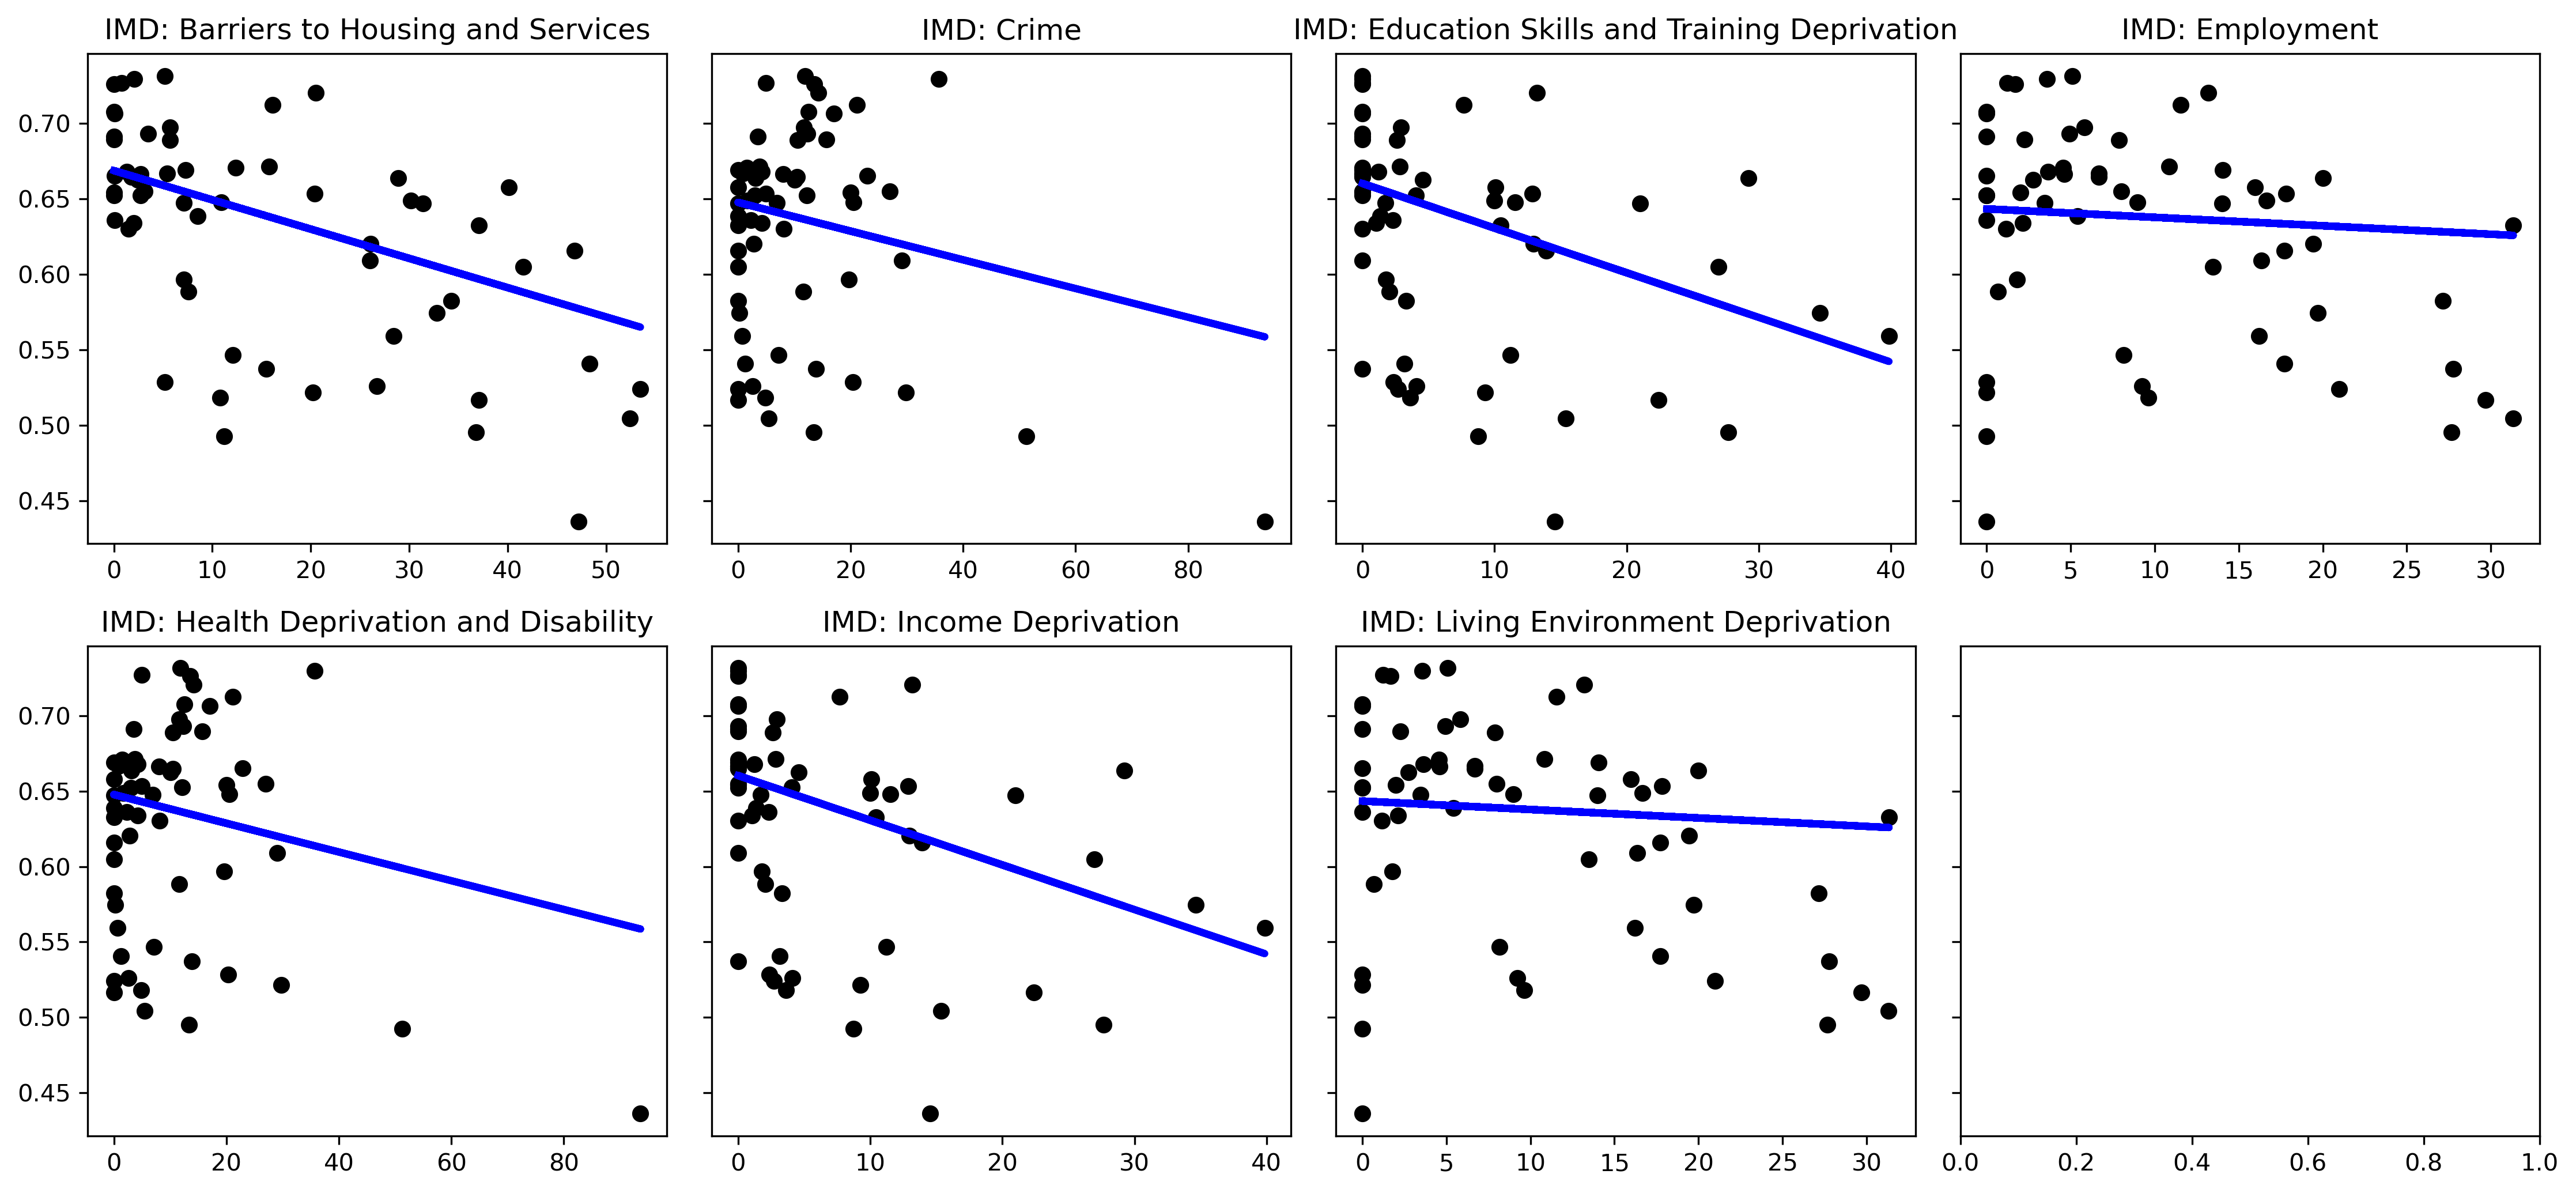

(None, None)

In [20]:
# perform linear regression on each IMD metric individually and plot
# outcome variable being the hesitancy measure calculated previously
rows,cols=2,4
title = 'Linear Regression of the Hesitancy Measure and IMD Metrics'


fig, axes = plt.subplots(figsize=(15,7),nrows=rows, ncols=cols, sharey=True)

for i in range(rows):
    for j in range(cols):
        if i*j==3:
            continue
        else:
            # Load the dataset
            X,y = hesitancy_by_imd_df.iloc[:,i+j],hesitancy_by_imd_df.iloc[:,-1]

            # Split the dataset into training, validation and test, using test_size=0.2
            Xtrain, Xtest, ytrain, ytest = train_test_split(X.values, y.values, test_size=0.2, random_state=0)
            regr = linear_model.LinearRegression()

            # Train the model using the training sets
            Xtrain,Xtest = Xtrain.reshape(-1, 1),Xtest.reshape(-1, 1)
            regr.fit(Xtrain, ytrain)

            # Make predictions using the testing set
            pred = regr.predict(Xtest)

            # The coefficients
            #print('Coefficients: \n', regr.coef_)

            print(IMD_metrics_df.iloc[:,(i*4)+j].name)
            
            # The mean squared error
            print('Mean squared error: %.4f'
                  % mean_squared_error(ytest, pred))

            # The coefficient of determination: 1 is perfect prediction
            print('Coefficient of determination: %.2f'
                  % r2_score(ytest, pred))

            # Plot outputs
            axes[i][j].scatter(Xtest, ytest,  color='black'),axes[i][j].plot(Xtest, pred, color='blue', linewidth=3)
            axes[i][j].set_title(IMD_metrics_df.iloc[:,(i*4)+j].name)
        
#fig.suptitle(title)
plt.savefig('./Desktop/MSc Project/Outputs/1' + title + '.png')
plt.tight_layout(),plt.show()

# Multiple Regression Models [Hesitancy Measure]

In [21]:
# perform multiple linear regression on all IMD metrics
# outcome variable being the hesitancy measure calculated previously
target = 'hesitancy measure'
overall = 'IMD: Overall - extent (%)'

# Load the dataset

# X contains the 7 IMD metrics divided by LTLA
X = hesitancy_by_imd_df.drop([target,overall],axis=1)

# y contains the hesitancy divided by LTLA
y = hesitancy_by_imd_df[target]

In [22]:
#UPDATE: apply z-score to X so that we can compare the model coefficients and therefore compare 'importance'
X_z = X.apply(stats.zscore)

In [23]:
# Split the dataset into training, validation and test, using test_size=0.2
Xtrain, Xtest, ytrain, ytest = train_test_split(X_z.values, y.values, test_size=0.2, random_state=0)
regr = linear_model.LinearRegression()

In [24]:
# Train the model using the training sets
model = regr.fit(Xtrain, ytrain)

In [25]:
# Make predictions using the testing set
pred = regr.predict(Xtest)

In [26]:
# model coefficients
model.coef_

array([-0.0115475 , -0.02162683,  0.01752541,  0.07454988, -0.00382829,
       -0.09530682,  0.00561221])

In [27]:
# model intercept

model.intercept_

0.6378717701594124

In [28]:
#  'r2_score is the (coefficient of determination) regression score function.
# Best possible score is 1.0 and it can be negative (because the model can be arbitrarily worse). A constant model 
# that always predicts the expected value of y, disregarding the input features, would get a score of 0.0.'

r2_score(ytest,pred)

0.36854625042192757

In [29]:
# list of IMD metric column names and the standardised multiple regression model coefficients
multi_regr_standard_coefs_ = list(zip(X_z.columns,model.coef_))

In [30]:
# sort them from largest to smallest
multi_regr_standard_coefs_.sort(key=lambda x: x[1])

In [31]:
# double check
multi_regr_standard_coefs_

[('IMD: Income Deprivation', -0.09530682287260332),
 ('IMD: Crime', -0.02162683416381639),
 ('IMD: Barriers to Housing and Services', -0.011547503370437365),
 ('IMD: Health Deprivation and Disability', -0.003828287205669631),
 ('IMD: Living Environment Deprivation', 0.005612205058711215),
 ('IMD: Education Skills and Training Deprivation', 0.017525411351398904),
 ('IMD: Employment', 0.07454988049064118)]

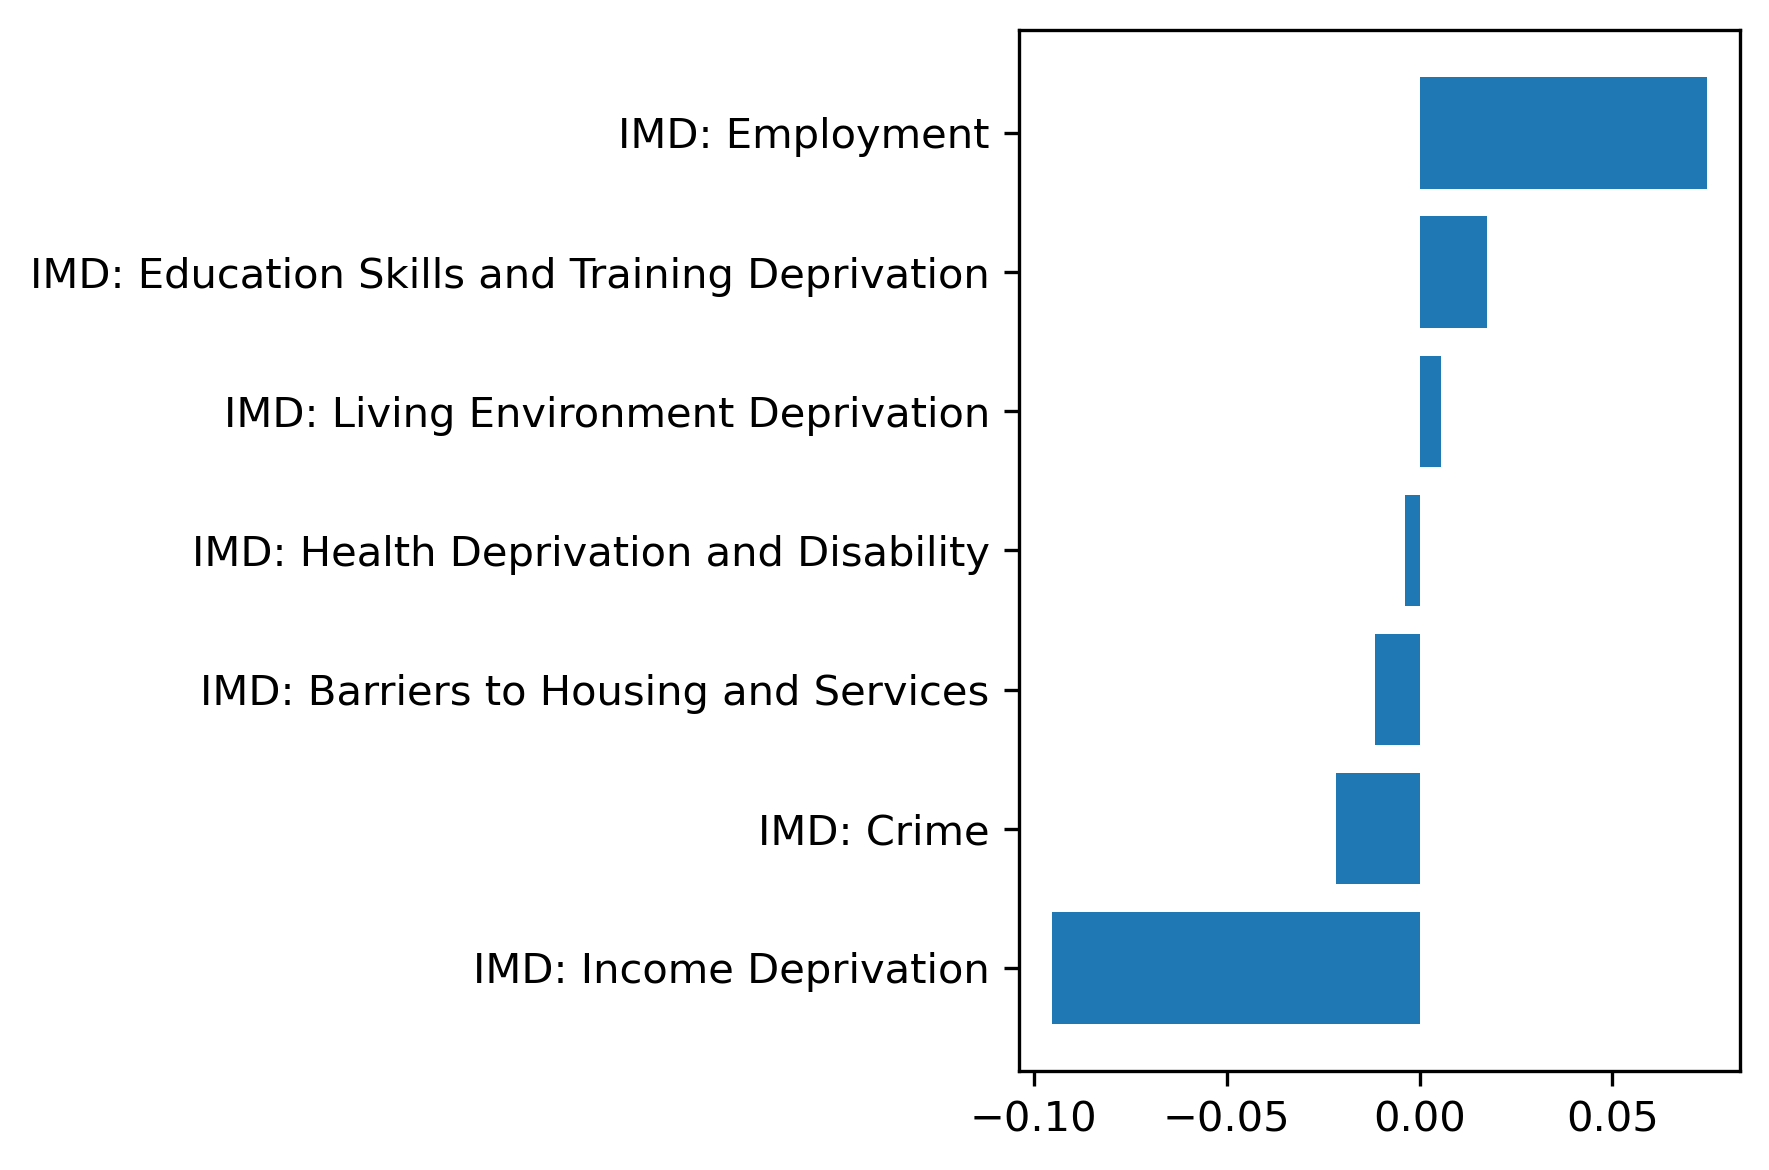

In [32]:
# plot coefficients
title = 'Multiple Linear Regression Model. How \'important\' is each IMD metric.'

plt.barh([tup[0] for tup in multi_regr_standard_coefs_],[tup[1] for tup in multi_regr_standard_coefs_])
#plt.title(title)
plt.tight_layout()
plt.savefig('./Desktop/MSc Project/Outputs/1' + title + '.png')
plt.show()

# Generalised Linear Regression Models [Hesitancy Measure]

### Load and split the data

In [33]:
# get data
X = X_z # the standardised IMD metrics
y = hesitancy_by_imd_df['hesitancy measure'] #the hesitancy measure calculated early

In [34]:
# Split the dataset into training, validation and test, using test_size=0.2
Xtrain, Xtest, ytrain, ytest = train_test_split(X.values, y.values, test_size=0.4, random_state=0)
Xval, Xtest, yval, ytest = train_test_split(Xtest, ytest, test_size=0.5, random_state=0)

### Initial model train and results

In [35]:
regr = TweedieRegressor(power=26, alpha=0.5, link='auto')

regr.fit(Xtrain, ytrain)

TweedieRegressor(alpha=0.5, power=26)

In [36]:
# Make predictions using the testing set
pred = regr.predict(Xtest)

In [37]:
regr.coef_

array([-0.03297172, -0.04202983,  0.14771038,  0.04325418, -0.01561856,
       -0.08172344, -0.01228077])

In [38]:
regr.intercept_

-0.4282010752546221

In [39]:
regr.n_iter_

61

In [40]:
#  'r2_score is the (coefficient of determination) regression score function.
# Best possible score is 1.0 and it can be negative (because the model can be arbitrarily worse). A constant model 
# that always predicts the expected value of y, disregarding the input features, would get a score of 0.0.'

r2_score(ytest,pred)

-1.0283233547780828

In [41]:
# list of IMD metric column names and the standardised multiple regression model coefficients
gen_regr_standard_coefs_ = list(zip(X_z.columns,regr.coef_))

In [42]:
# sort them from largest to smallest
gen_regr_standard_coefs_.sort(key=lambda x: x[1])

In [43]:
# double check
gen_regr_standard_coefs_

[('IMD: Income Deprivation', -0.08172343549908517),
 ('IMD: Crime', -0.042029831751710704),
 ('IMD: Barriers to Housing and Services', -0.03297172147380403),
 ('IMD: Health Deprivation and Disability', -0.015618555176218196),
 ('IMD: Living Environment Deprivation', -0.012280766240021295),
 ('IMD: Employment', 0.04325418370545512),
 ('IMD: Education Skills and Training Deprivation', 0.14771038021792507)]

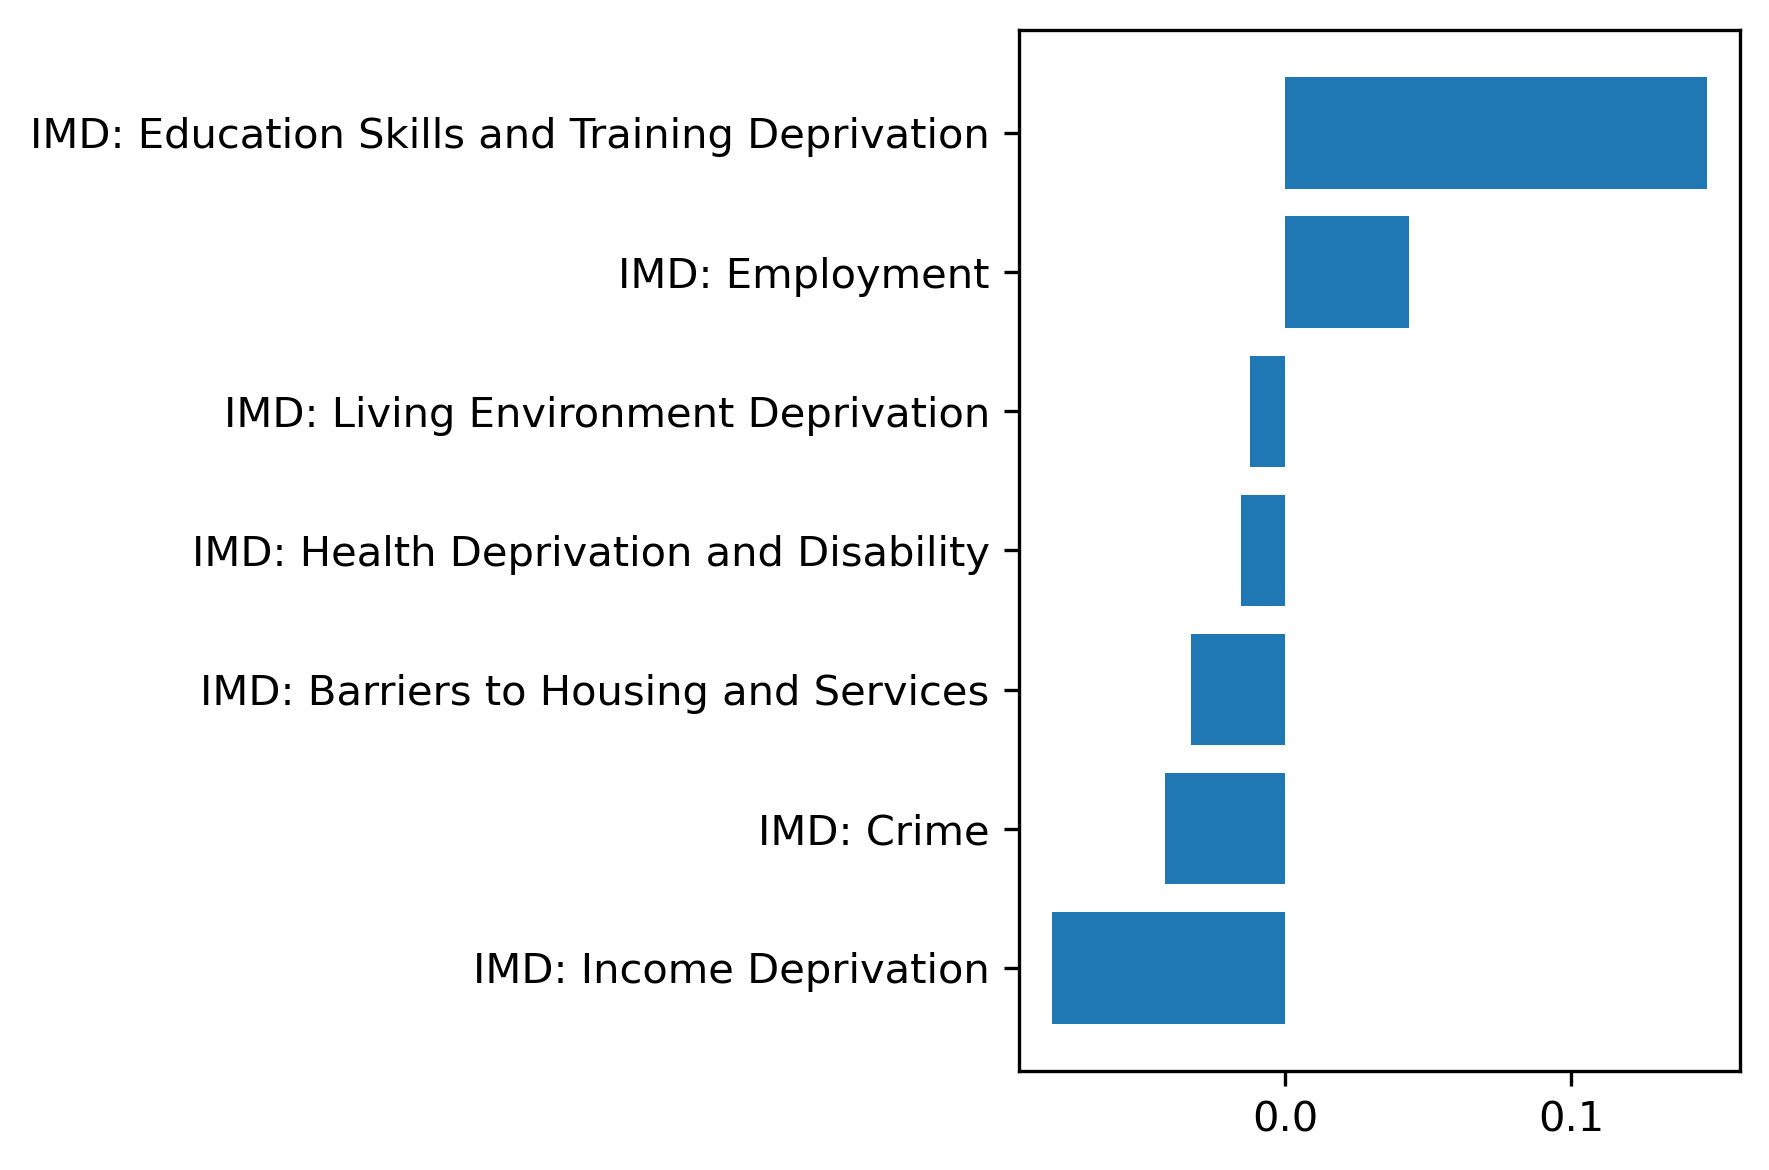

In [44]:
# plot coefficients
title = 'General Linear Regression Model. How \'important\' is each IMD metric'

plt.barh([tup[0] for tup in gen_regr_standard_coefs_],[tup[1] for tup in gen_regr_standard_coefs_])

plt.tight_layout()
plt.savefig('./Desktop/MSc Project/Outputs/1' + title + '.png')
#plt.title(title)
plt.show()

---

## Tuning hyperparameters

##### 'Best' power value, p, in TweedieRegressor (i.e. what is the underlying target distribution according)?

In [45]:
# make predictions and accuracy scores using the validation set on different power values, p, within TweedieRegressor
power_values = list(np.linspace(1,20,191))
power_values.insert(0,0.0)
power_values_r2_scores = []

for p in power_values:
    # instantiate the model
    regr = TweedieRegressor(power=p, alpha=0.5, link='auto')

    # fit using the training data
    regr.fit(Xtrain, ytrain)

    # make predictions using the validation set
    pred = regr.predict(Xval)
    
    # calculate and store the r2_score for each values of p
    acc = r2_score(yval,pred)
    power_values_r2_scores.append((p,acc))

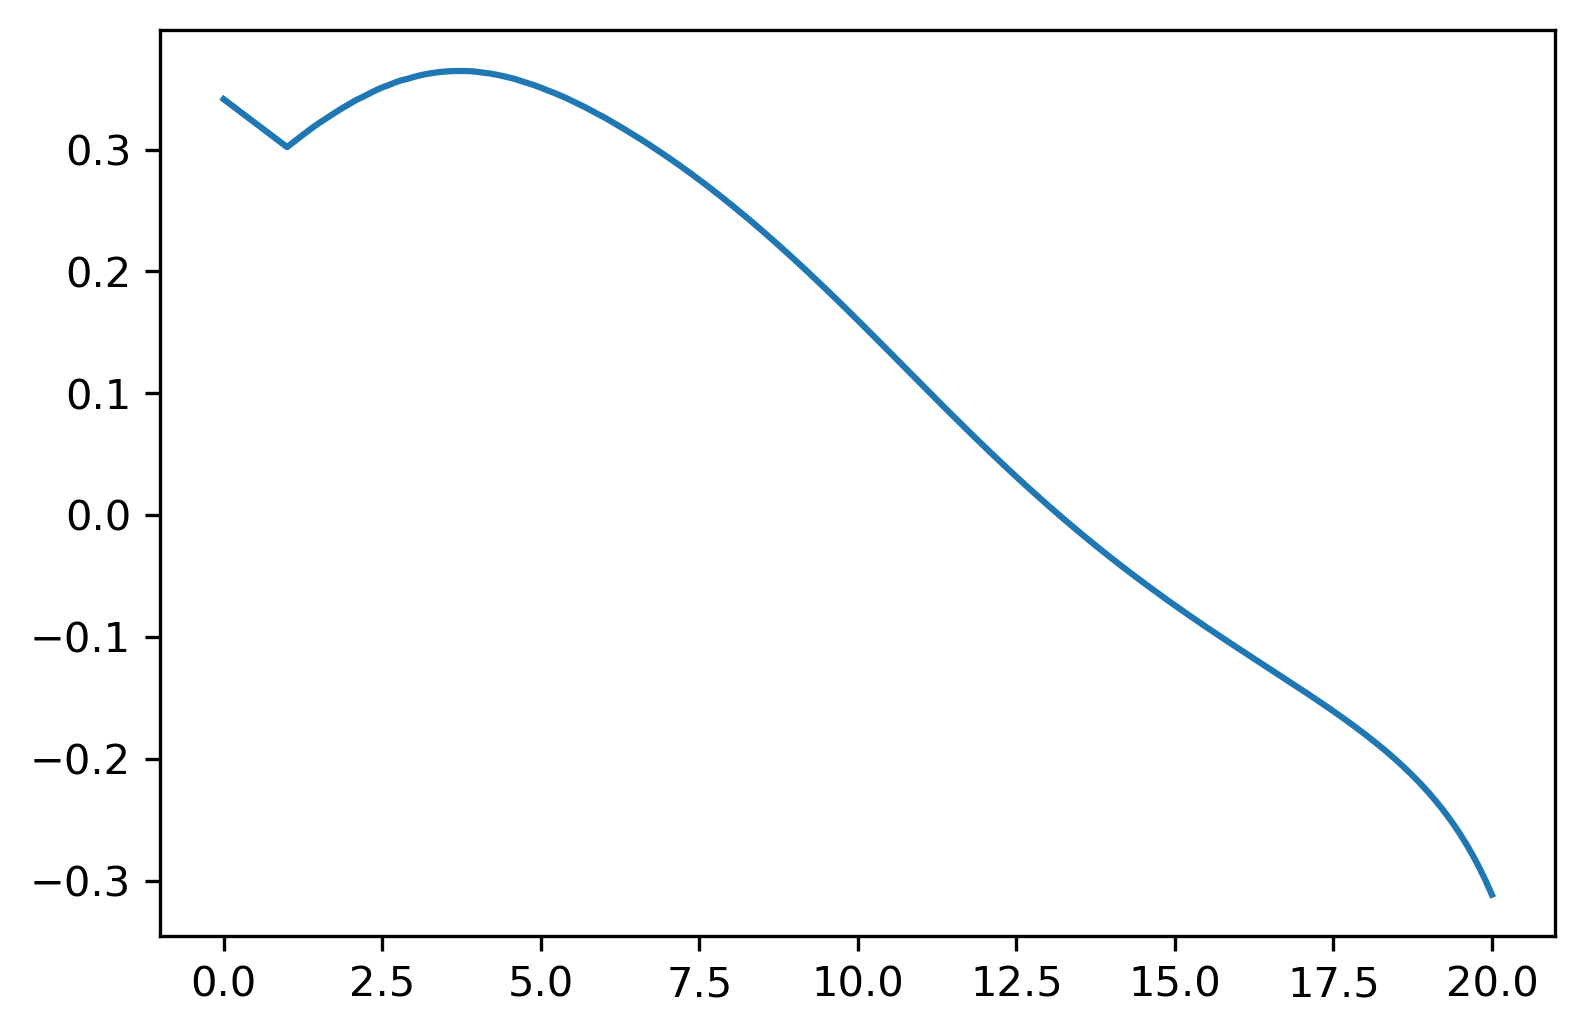

In [46]:
# plot hyperparamter tuning
title = 'Which power value gives the highest R-squared accuracy score'

plt.plot([tup[0] for tup in power_values_r2_scores],[tup[1] for tup in power_values_r2_scores])

#plt.title(title)
plt.savefig('./Desktop/MSc Project/Outputs/1' + title + '1.png')
plt.show()

In [47]:
max(power_values_r2_scores, key=lambda x:x[1])

(3.8000000000000003, 0.3643746619896281)

In [48]:
# SAME AS ABOVE BUT A SMALLER RANGE OF P VALUES

# make predictions and accuracy scores using the validation set on different power values, p, within TweedieRegressor
power_values = list(np.linspace(1,10,901))
power_values.insert(0,0.0)
power_values_r2_scores = []

for p in power_values:
    # instantiate the model
    regr = TweedieRegressor(power=p, alpha=0.5, link='auto')

    # fit using the training data
    regr.fit(Xtrain, ytrain)

    # make predictions using the validation set
    pred = regr.predict(Xval)
    
    # calculate and store the r2_score for each values of p
    acc = r2_score(yval,pred)
    power_values_r2_scores.append((p,acc))

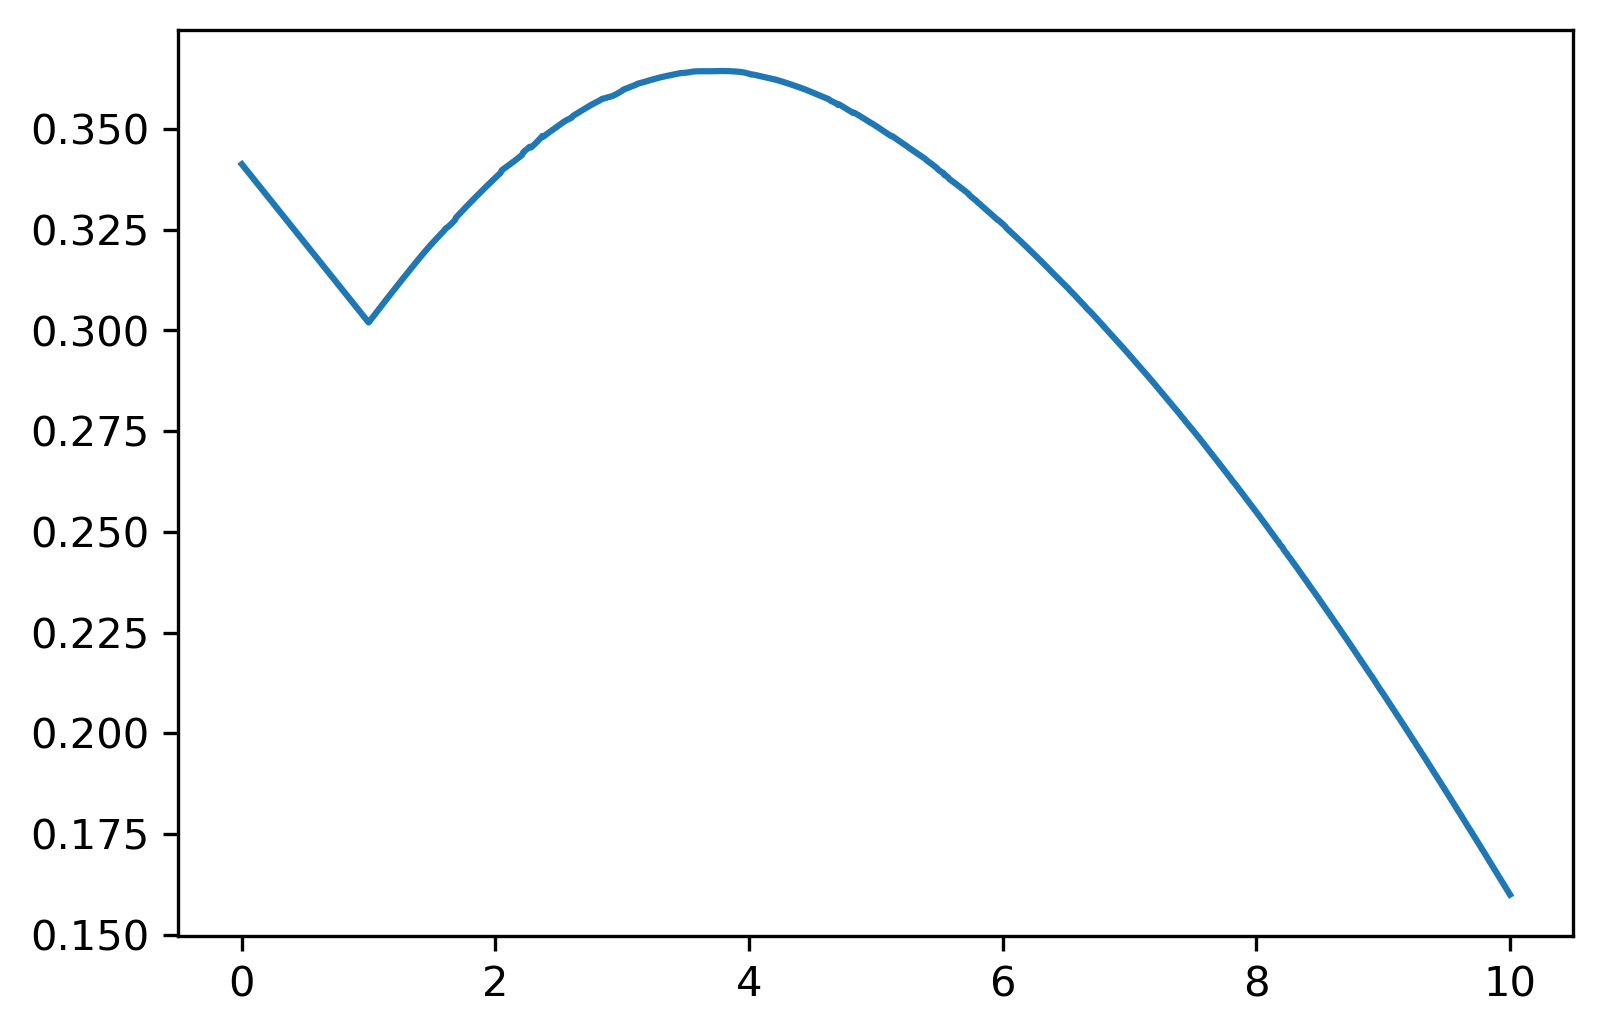

In [49]:
# plot hyperparamter tuning
title = 'Which power value gives the highest R-squared accuracy score'

plt.plot([tup[0] for tup in power_values_r2_scores],[tup[1] for tup in power_values_r2_scores])

plt.savefig('./Desktop/MSc Project/Outputs/1' + title + '2.png')
#plt.title(title)
plt.show()

In [50]:
max(power_values_r2_scores, key=lambda x:x[1])

(3.7800000000000002, 0.36437719063614604)

Seem like the best power value is p=3.78

### accuracy on the test set

In [51]:
p=max(power_values_r2_scores, key=lambda x:x[1])[0]

In [52]:
# instantiate the model
regr = TweedieRegressor(power=p, alpha=0.5, link='auto')

# fit using the training data
regr.fit(Xtrain, ytrain)

# make predictions using the validation set
pred = regr.predict(Xtest)
    
# calculate and store the r2_score for each values of p
acc = r2_score(ytest,pred)

print('R squared accuracy on test set with power value =', p, 'is', acc)

R squared accuracy on test set with power value = 3.7800000000000002 is 0.2038925864885106


##### 'Best' alpha value, a, in TweedieRegressor (i.e. the constant that multiplies the penalty term and thus determines the regularization strength.)?

In [53]:
# make predictions and accuracy scores using the validation set on different alpha values, a, within TweedieRegressor
alpha_values = list(np.linspace(0,10,1001))
alpha_values_r2_scores = []

for a in alpha_values:
    # instantiate the model
    regr = TweedieRegressor(power=3.65, alpha=a, link='auto')

    # fit using the training data
    regr.fit(Xtrain, ytrain)

    # make predictions using the validation set
    pred = regr.predict(Xval)
    
    # calculate and store the r2_score for each values of p
    acc = r2_score(yval,pred)
    alpha_values_r2_scores.append((a,acc))

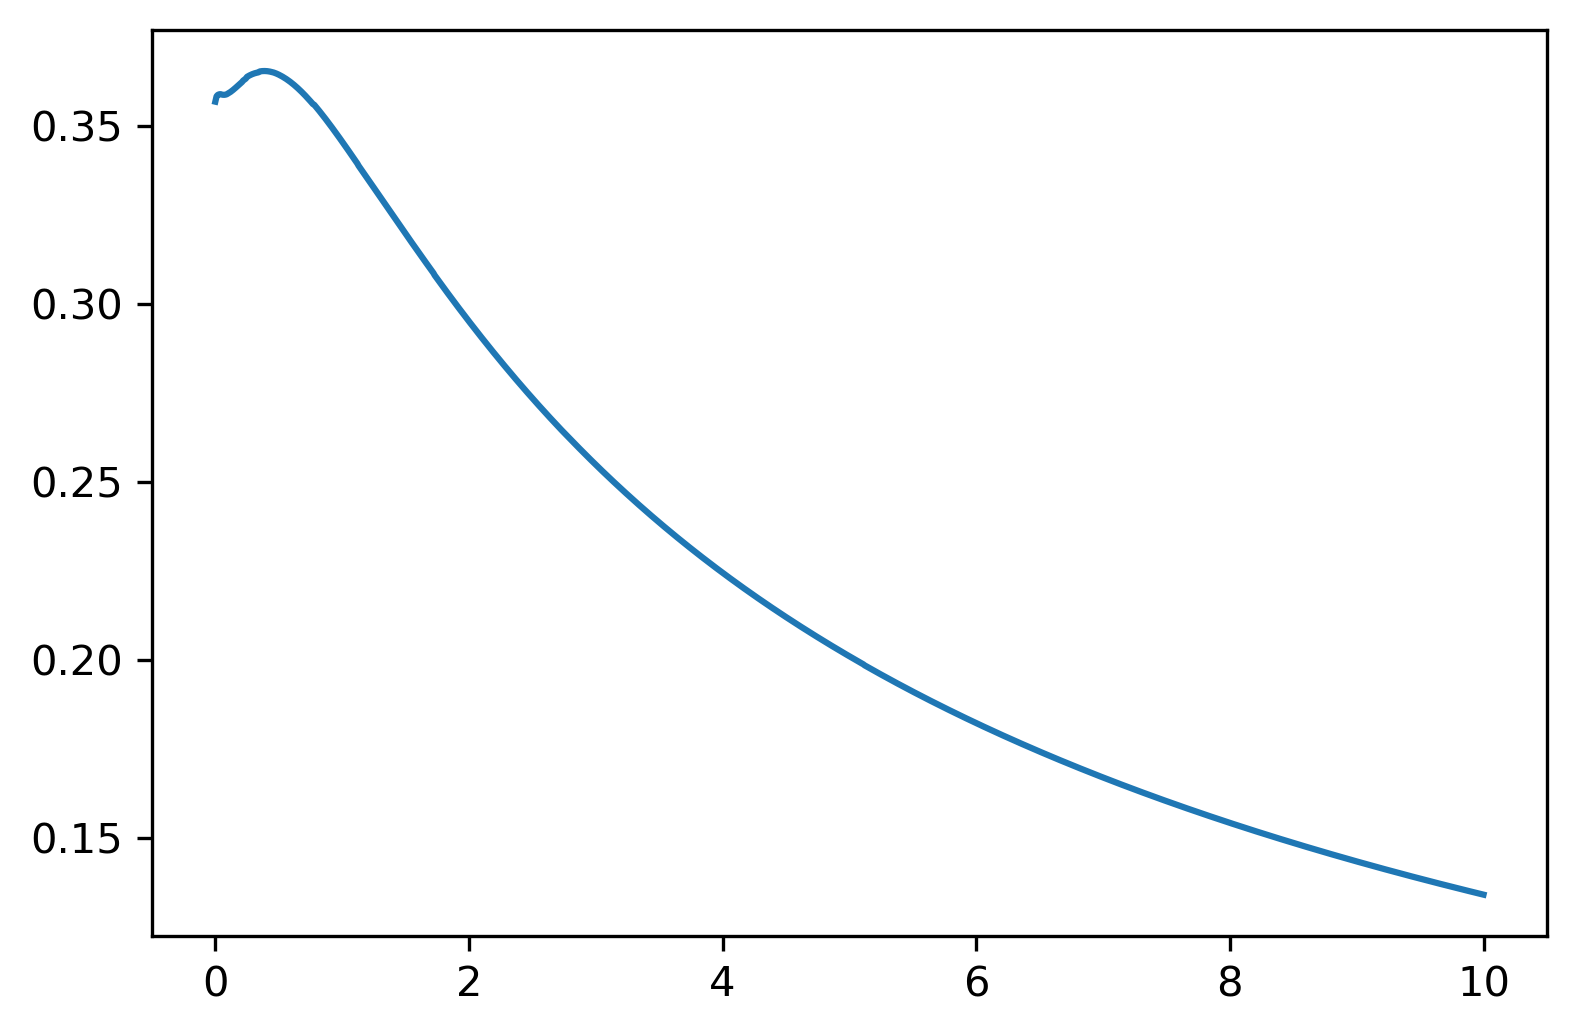

In [54]:
# plot hyperparamter tuning
title = 'Which alpha value gives the highest R-squared accuracy score'

plt.plot([tup[0] for tup in alpha_values_r2_scores],[tup[1] for tup in alpha_values_r2_scores])

#plt.title(title)
plt.savefig('./Desktop/MSc Project/Outputs/1' + title + '1.png')
plt.show()

In [55]:
max(alpha_values_r2_scores, key=lambda x:x[1])

(0.39, 0.36533107202127924)

In [56]:
# SAME AS ABOVE BUT A SMALLER RANGE OF A VALUES

# make predictions and accuracy scores using the validation set on different alpha values, a, within TweedieRegressor
alpha_values = list(np.linspace(0,1,101))
alpha_values_r2_scores = []

for a in alpha_values:
    # instantiate the model
    regr = TweedieRegressor(power=3.65, alpha=a, link='auto')

    # fit using the training data
    regr.fit(Xtrain, ytrain)

    # make predictions using the validation set
    pred = regr.predict(Xval)
    
    # calculate and store the r2_score for each values of p
    acc = r2_score(yval,pred)
    alpha_values_r2_scores.append((a,acc))

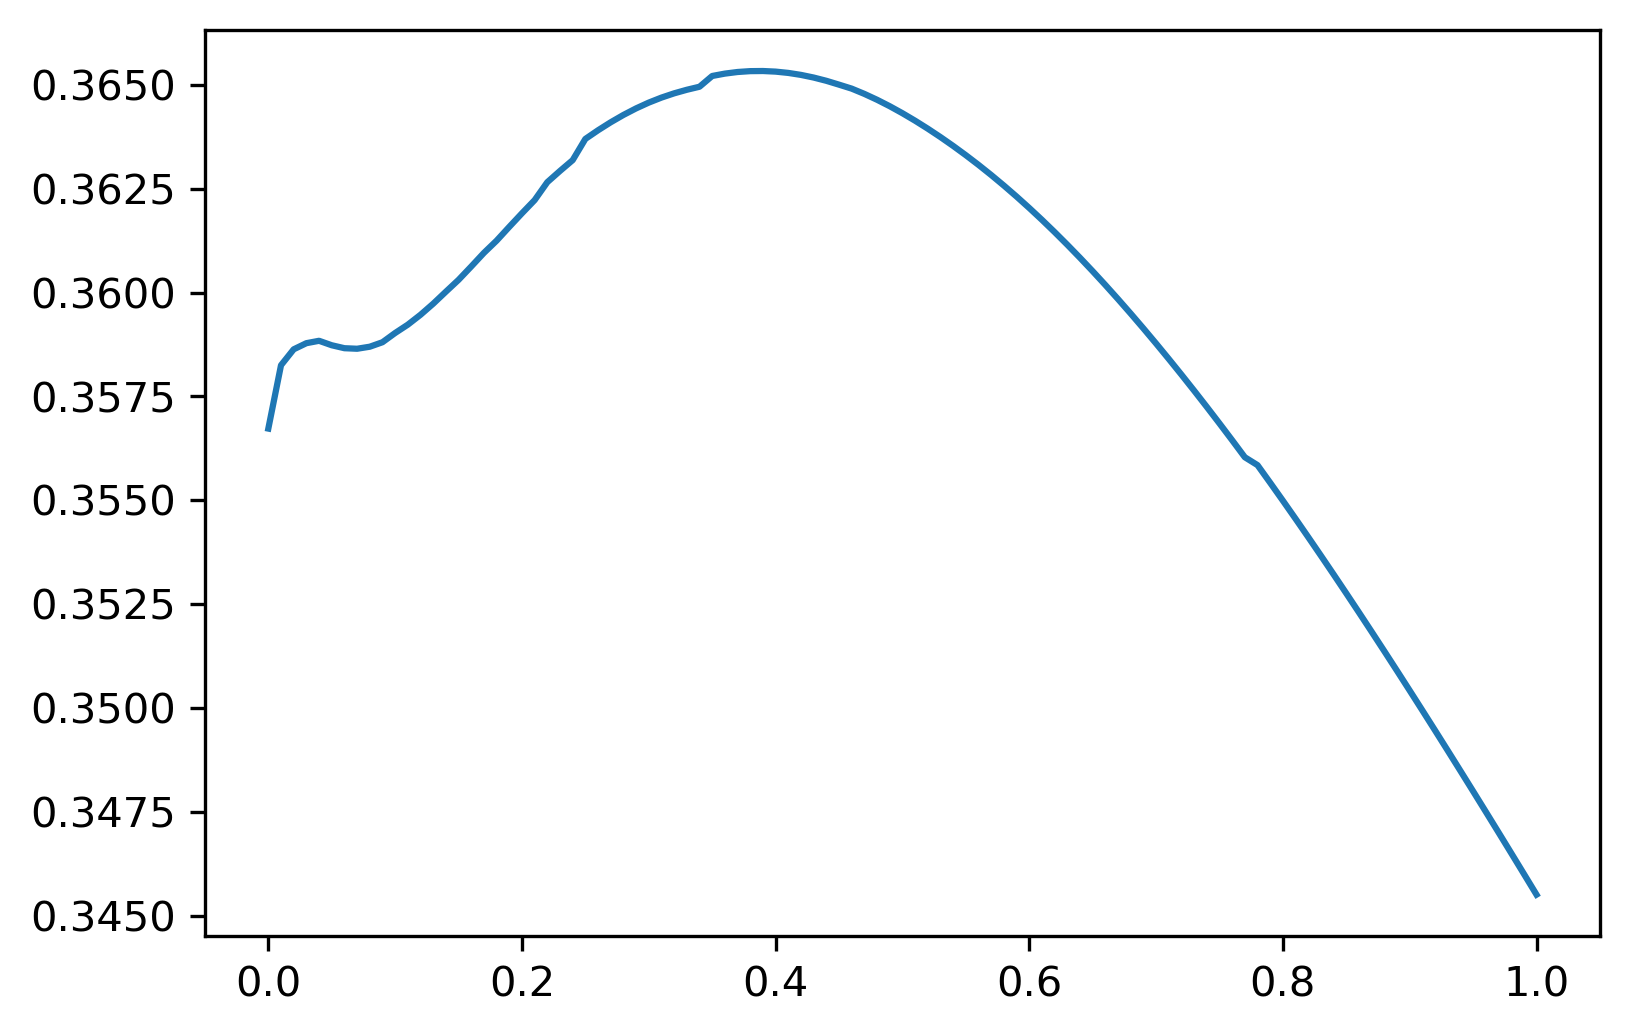

In [57]:
# plot hyperparamter tuning
title = 'Which alpha value gives the highest R-squared accuracy score'

plt.plot([tup[0] for tup in alpha_values_r2_scores],[tup[1] for tup in alpha_values_r2_scores])

plt.savefig('./Desktop/MSc Project/Outputs/1' + title + '2.png')
#plt.title(title)
plt.show()

In [67]:
max(alpha_values_r2_scores, key=lambda x:x[1])

(0.39, 0.36533107202127924)

Seem like the best alpha value is a=0.39

### accuracy on the test set

In [59]:
a=max(alpha_values_r2_scores, key=lambda x:x[1])[0]

In [60]:
# instantiate the model
regr = TweedieRegressor(power=3.65, alpha=a, link='auto')

# fit using the training data
regr.fit(Xtrain, ytrain)

# make predictions using the validation set
pred = regr.predict(Xtest)
    
# calculate and store the r2_score for each values of p
acc = r2_score(ytest,pred)

print('R squared accuracy on test set with alpha value =', a, 'is', acc)

R squared accuracy on test set with alpha value = 0.39 is 0.20954164772404027


### Model after hyperparameter tuning

In [61]:
# instantiate the model
regr = TweedieRegressor(power=p, alpha=a, link='auto')

# fit using the training data
regr.fit(Xtrain, ytrain)

# make predictions using the validation set
pred = regr.predict(Xtest)

In [62]:
#  'r2_score is the (coefficient of determination) regression score function.
# Best possible score is 1.0 and it can be negative (because the model can be arbitrarily worse). A constant model 
# that always predicts the expected value of y, disregarding the input features, would get a score of 0.0.'

r2_score(ytest,pred)

0.21114775480905534

In [63]:
# list of IMD metric column names and the standardised multiple regression model coefficients
multi_regr_standard_coefs_ = list(zip(X_z.columns,regr.coef_))
multi_regr_standard_coefs_

[('IMD: Barriers to Housing and Services', -0.02627610065643918),
 ('IMD: Crime', -0.04503749253738417),
 ('IMD: Education Skills and Training Deprivation', 0.028871905085202463),
 ('IMD: Employment', 0.022016885257666433),
 ('IMD: Health Deprivation and Disability', 0.006122212350596168),
 ('IMD: Income Deprivation', -0.04991806060091196),
 ('IMD: Living Environment Deprivation', -0.0007807381090927864)]

In [64]:
# sort them from largest to smallest
multi_regr_standard_coefs_.sort(key=lambda x: x[1])
multi_regr_standard_coefs_

[('IMD: Income Deprivation', -0.04991806060091196),
 ('IMD: Crime', -0.04503749253738417),
 ('IMD: Barriers to Housing and Services', -0.02627610065643918),
 ('IMD: Living Environment Deprivation', -0.0007807381090927864),
 ('IMD: Health Deprivation and Disability', 0.006122212350596168),
 ('IMD: Employment', 0.022016885257666433),
 ('IMD: Education Skills and Training Deprivation', 0.028871905085202463)]

In [65]:
# double check
multi_regr_standard_coefs_

[('IMD: Income Deprivation', -0.04991806060091196),
 ('IMD: Crime', -0.04503749253738417),
 ('IMD: Barriers to Housing and Services', -0.02627610065643918),
 ('IMD: Living Environment Deprivation', -0.0007807381090927864),
 ('IMD: Health Deprivation and Disability', 0.006122212350596168),
 ('IMD: Employment', 0.022016885257666433),
 ('IMD: Education Skills and Training Deprivation', 0.028871905085202463)]

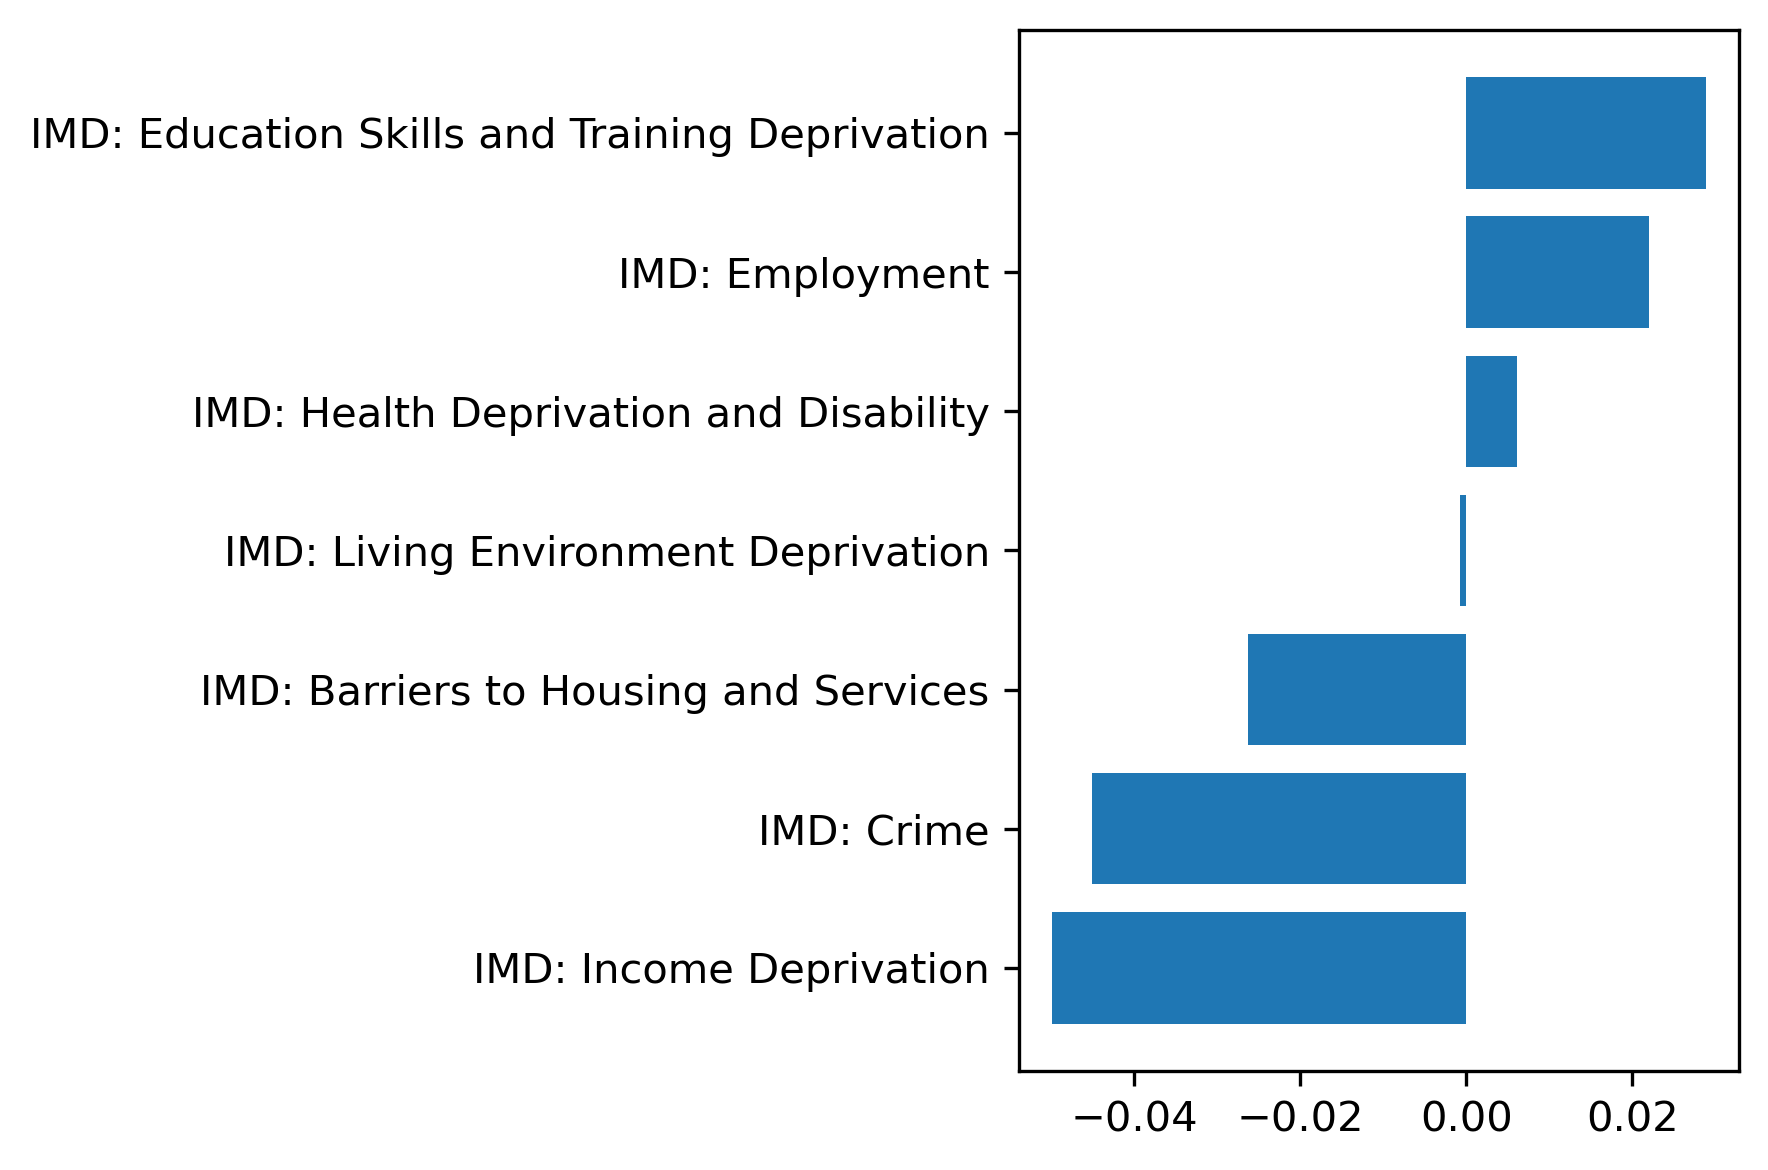

In [68]:
# plot coefficients
title = 'General Linear Regression Model after hyperparameter tuning. How \'important\' is each IMD metric'

plt.barh([tup[0] for tup in multi_regr_standard_coefs_],[tup[1] for tup in multi_regr_standard_coefs_])

plt.tight_layout()
plt.savefig('./Desktop/MSc Project/Outputs/1' + title + '.png')
#plt.title(title)
plt.show()